#                                      Analysis of New York City Taxi Data
By: Thomas Giddings

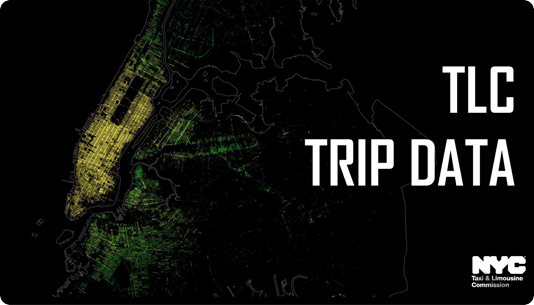

These libraries contain some basic functionality that we will require to perform an analysis on our data.
Pandas provides dataframes that function as advanced tables with easy to use lookup and analysis functions.
Matplotlib is the basis of plotting data in most python implementations.
Seaborn will allow us to make much more appealing looking and unique kinds of plots.
numpy is an important array and number manipulation library.
Statsmodels will allow us to perform regressions on our data to try to predict values.

In [2]:
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

                                            #Curating Our Data

This data is provided by Amazon via Amazon Web Services, as one of the many datasets available. It is a large amount of data from New York taxis, both Yellow Cab and Green Taxi. This contains information about date and time, start points, endpoint, fares, tips, distance, and a few other data points.
We will be using the June 2018 data for this tutorial. http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

This data will be collected and processed using Pandas, the documentation for which can be found here: http://pandas.pydata.org/pandas-docs/stable/

In [3]:
ydata = pd.read_csv("yellow_tripdata_2018-06.csv", nrows=150000) 
#We have to limit the number of rows in order to ease 
#The process of loading the data into memory.

In [4]:
gdata = pd.read_csv("green_tripdata_2018-06.csv", nrows=150000)

Let's drop a few columns that we won't be using in this tutorial.

In [5]:
ydata = ydata.drop('store_and_fwd_flag', axis=1)
gdata = gdata.drop('store_and_fwd_flag', axis=1)
ydata = ydata.drop('extra', axis=1)
gdata = gdata.drop('extra', axis=1)
ydata = ydata.drop('mta_tax', axis=1)
gdata = gdata.drop('mta_tax', axis=1)
ydata = ydata.drop('tolls_amount', axis=1)
gdata = gdata.drop('tolls_amount', axis=1)
ydata = ydata.drop('improvement_surcharge', axis=1)
gdata = gdata.drop('improvement_surcharge', axis=1)

In [6]:
#Let's take a look at our data
ydata.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount
0,1,2018-06-01 00:15:40,2018-06-01 00:16:46,1,0.0,1,145,145,2,3.0,0.00,4.30
1,1,2018-06-01 00:04:18,2018-06-01 00:09:18,1,1.0,1,230,161,1,5.5,1.35,8.15
2,1,2018-06-01 00:14:39,2018-06-01 00:29:46,1,3.3,1,100,263,2,13.0,0.00,14.30
3,1,2018-06-01 00:51:25,2018-06-01 00:51:29,3,0.0,1,145,145,2,2.5,0.00,3.80
4,1,2018-06-01 00:55:06,2018-06-01 00:55:10,1,0.0,1,145,145,2,2.5,0.00,3.80


In [7]:
gdata.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,tip_amount,ehail_fee,total_amount,payment_type,trip_type
0,2,2018-06-01 00:33:55,2018-06-01 00:36:13,1,66,33,5,0.51,4.0,0.70,NaN,6.00,1,1
1,2,2018-06-01 00:40:36,2018-06-01 00:49:46,1,25,49,5,1.97,9.0,2.06,NaN,12.36,1,1
2,2,2018-06-01 00:57:12,2018-06-01 01:02:58,1,61,49,5,1.40,6.5,0.00,NaN,7.80,2,1
3,2,2018-06-01 00:10:13,2018-06-01 00:16:27,1,49,97,1,1.36,7.0,0.00,NaN,8.30,2,1
4,1,2018-06-01 00:32:08,2018-06-01 00:52:06,1,75,127,1,7.90,24.0,6.30,NaN,31.60,1,1


For our purposes, we don't need all of the data we've been given. In order to make our analysis of fares more consistent, let's get rid of rows with non-standard fare rates, where RatecodeID does not equal 1. Other rate codes may include features such as flat rates, so we don't want those to interfere with our regression later.

In [185]:
ydata = ydata.drop(ydata[ydata.RatecodeID != 1].index)
gdata = gdata.drop(gdata[gdata.RatecodeID != 1].index)

The current form of the time isn't very convenient for analytical purposes for us, so let's use numpy's datetime to add an additional column containing the total time in seconds of each trip. This new column will assist us in further editing and analysis of our data.

In [186]:
ydata['time_seconds'] = 0.0 #Create a new column

for index, row in ydata.iterrows():
    dif = np.datetime64(row['tpep_dropoff_datetime']) - np.datetime64(row['tpep_pickup_datetime']) #Calculate time difference
    ydata.at[index, 'time_seconds'] = dif.item().total_seconds() #Alter the entry

In [187]:
gdata['time_seconds'] = 0.0

for index, row in gdata.iterrows():
    dif = np.datetime64(row['lpep_dropoff_datetime']) - np.datetime64(row['lpep_pickup_datetime'])
    gdata.at[index, 'time_seconds'] = dif.item().total_seconds()

We can use our new column to create another column to record the average speed of each trip based on its time and distance statistics.

In [188]:
gdata['speed'] = 0.0

for index, row in gdata.iterrows():
    if (row['time_seconds'] != 0):
        gdata.at[index, 'speed'] = row['trip_distance'] / (row['time_seconds'] / 3600)
    else:
        gdata.at[index, 'speed'] = np.nan #Dividing by 0 is undefined, of course

In [189]:
ydata['speed'] = 0.0

for index, row in ydata.iterrows():
    if (row['time_seconds'] != 0):
        ydata.at[index, 'speed'] = row['trip_distance'] / (row['time_seconds'] / 360)
    else:
        ydata.at[index, 'speed'] = np.nan

Using this data, we can also make an analysis based on time.
Now that we've cleaned our data based on RatecodID, we don't need the column any more as it will always be 1, making it rather irrelevant.

In [190]:
ydata = ydata.drop('RatecodeID', axis=1)
gdata = gdata.drop('RatecodeID', axis=1)

In [191]:
dates = pd.DatetimeIndex(ydata['tpep_pickup_datetime'])
ydata['hour'] = dates.hour

                                          Exploratory Data Analysis

With our data all put together, it's time to do some preliminary analysis in order to visualize and get a feel for our newly obtained data. This is important to make sure that we have the data we want, in the format we want.

First, let's plot our data as a visualization tool. This allows us to see aspects of our data like skew.
Let's start with a frequency plot of distance.

We will be using SeaBorn for most of this section, the documentation can be found here: https://seaborn.pydata.org/

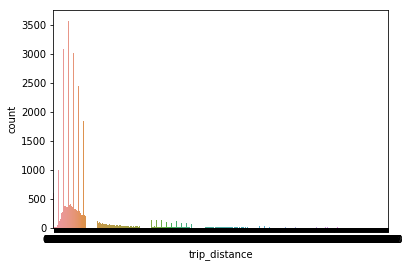

In [192]:
ax = sns.countplot(x="trip_distance", data=ydata)
plt.show()

This plot shows us that our data is skewed pretty heavily downwards. However, it is very hard to make out any details and our x-axis labels overlap significantly. To make our plot readable, let's round all of our data to the nearest whole number, rotate our labels, and increase the plot size.

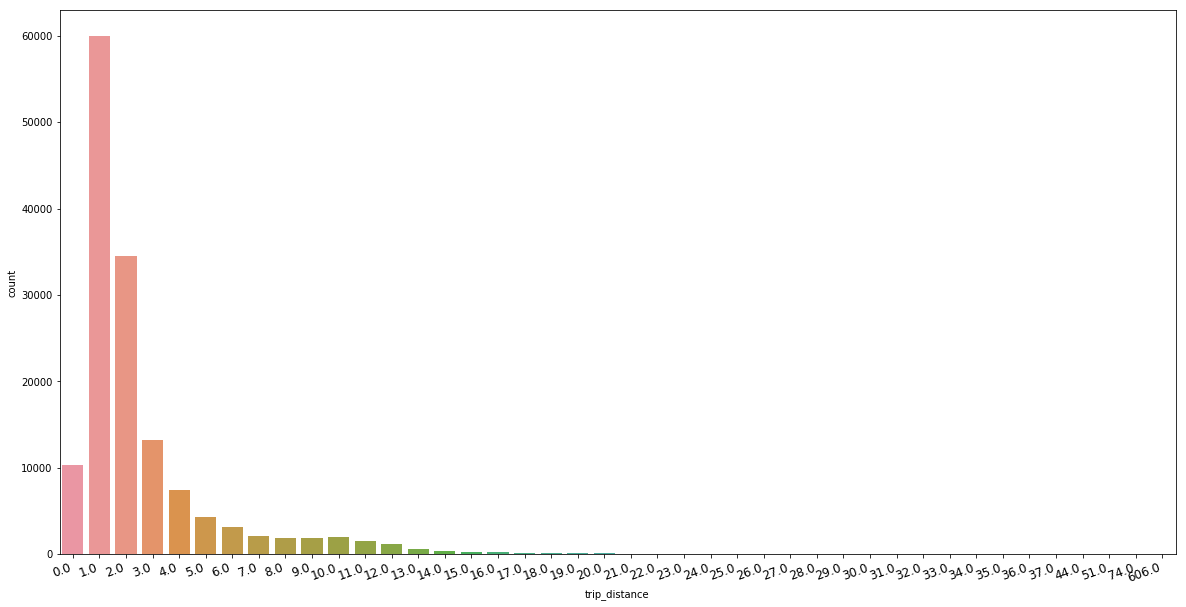

In [193]:
plt.subplots(figsize=(20,10)) #Increase the size
ax = sns.countplot(x="trip_distance", data=ydata.round(0)) #Round the data to reduce x values
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right", fontsize=12) #set rotation and font size
plt.show()

Now that we can actually read the labels, we can see quite clearly that most of our trips seem to cover a distance of around 1 mile. It is, as previously noted, quite heavily skewed towards the low end of the graph. While there are some outliers increasing the range of this plot, most values are not above 20 or so miles total.

Next, let's plot distance against the total fare on a scatter plot.

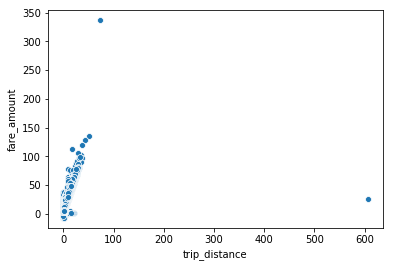

In [194]:
sns.scatterplot(ydata['trip_distance'], ydata['fare_amount'])
plt.show()

We can see that, outside of an outlier, that our data seems to be clustered around a line that increases at a constant rate. This will be important later for our regression of the data, but for now, let's just jot that down as a notable feature.

Let's do the same with total fares and tips paid.

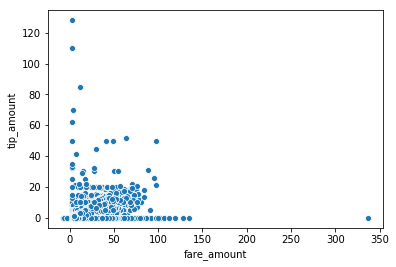

In [195]:
sns.scatterplot(ydata['fare_amount'], ydata['tip_amount'])
plt.show()

As may have been expected, this graph isn't nearly as strictly linear as the above. This isn't surprising, considering that the fare amount has an enforced relation to distance traveled, but tips are not necessarily tied to the size of the fare.

In some cases, people may also choose not to tip, or to tip more generously than the usual.

In this case, our preliminary analysis has revealed a potential issue. If we're a careful reader and noticed that our documentation tells us we have missing data, something stands out. Cash payment of tips are not tracked, only those made via credit card. More on missing data in later parts.

For now, let's continue looking at our data.

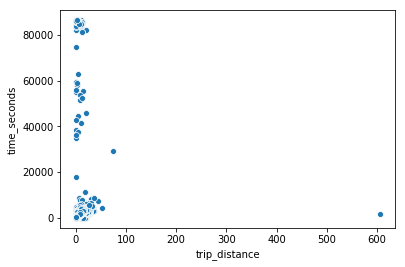

In [196]:
sns.scatterplot(ydata['trip_distance'], ydata['time_seconds'])
plt.show()

We have a bit of an issue with an outlier here, so let's trim it for visibility's sake.

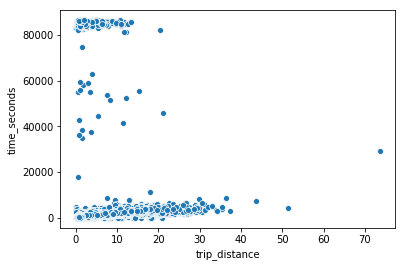

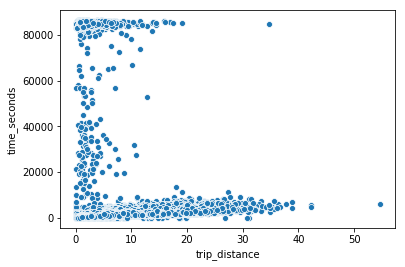

In [197]:
sns.scatterplot(ydata.loc[ydata['trip_distance'] < 200]['trip_distance'], #Only entries with distance < 200
                ydata.loc[ydata['trip_distance'] < 200]['time_seconds'])
plt.show()
sns.scatterplot(gdata['trip_distance'], gdata['time_seconds'])
plt.show()

Something should strike us as being wrong here. There seems to be a rather high distance values associated with low time values on our plot, which may indicate that some of our data might be incorrect. Let's take a look at our speed to get an idea.

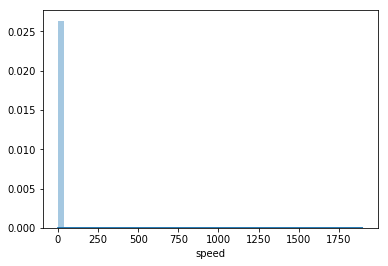

In [198]:
sns.distplot(ydata['speed'].dropna(0)) #Disregard values that are not a number
plt.show()

Most of our data seems to trend in the "less than 250" bucket, which is quite unsurprising, but some speeds seem to be in excess of 1750 miles per hour.
Unless Yellow Cab has failed to report a driver breaking the land speed record, it seems unlikely that this is an actual speed and not an error.
Let's trim the data a bit to see more actual speeds.

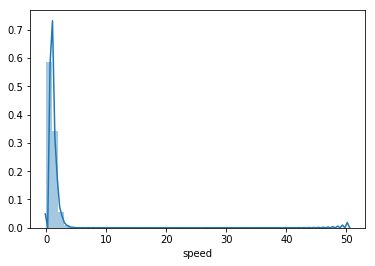

In [199]:
sns.distplot(ydata.loc[ydata['speed'] < 60].dropna(0)['speed'])
plt.show()

Now that we can see more of our data, it is evident that our data is clustered rather low on this plot. It is heavily skewed towards the low end, and only slightly bumps on the high end. It seems that most taxis in NYC don't get around terribly quickly.

                                                 Hypothesis Testing and Analysis
Now that we've cleaned up our data a bit, and taken a good look at it, let's try doing some analysis. For this part, we will mostly be using linear regression to try to perform predictions on various parts of our dataset. For our first analysis, let's try to predict the fare being charged by the taxi service relative to the distance traveled.

In [200]:
y = np.array(ydata['fare_amount']) #Make the y value array
X = np.array(ydata['trip_distance']) #X value array
model = sm.OLS(y,X) #Create model based on those values
regression= model.fit() #Fit your new regression!

Now that we have a regression fitted, let's make a hypothesis to test. Our hypothesis will be that the relation between these two values is linear. In order to prove this, we will fit a linear regression using the statsmodels api. We are trying to reject the null hypothesis. The null hypothesis, then, will be that the relation is non-linear.
the documentation for linear regression in statsmodels is found here: https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html

In order to reject the null hypothesis with a 95% confidence interval, our p-value must be below .05 according to this website,
so let's check our new model's p-value: https://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/

In [201]:
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                 5.235e+05
Date:                Sat, 15 Dec 2018   Prob (F-statistic):               0.00
Time:                        14:41:10   Log-Likelihood:            -4.8682e+05
No. Observations:              145426   AIC:                         9.736e+05
Df Residuals:                  145425   BIC:                         9.737e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.1333      0.004    723.531      0.000       3.125       3.142
==============================================================================
Omnibus:                   763120.931   Durbin-Watson:                   1.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   44506331926475.039
Skew:                        -256.460   Prob(JB):                         0.00
Kurtosis:                   85704.360   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since our p-value is 0, we can reject the null hypothesis with very high certainty, as this suggests that the linear relation is very strong. This is exactly what we would expect, as taxi services charge based on distance traveled over the course of each trip. Now, let's take a quick look at this line imposed over a scatter plot of some of our data.

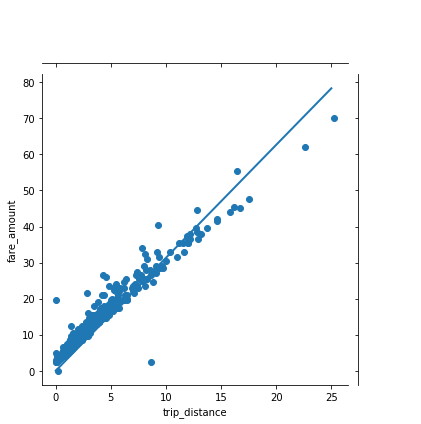

In [202]:
y1 = regression.predict(0) #We can use our regression to predict y with a hypothetical x (0, in this case)
y2 = regression.predict(25)
graph = sns.JointGrid(ydata['trip_distance'].head(500), ydata['fare_amount'].head(500)) 
#Only taking 500 entries, to keep the plot clean
graph.plot_joint(plt.scatter)
plt.plot([0, 25], [y1, y2], linewidth=2)
plt.show()

As expected, this line is a pretty good predictor of fare amounts based on distance traveled.
For our purposes, though, we would like to determine something a little less obvious. For example, let's try to predict tipping rates. For this, we will do something similar, but comparing fare_amount to tip_amount. This should give us an idea of what percentage of the fare people usually tip! This should be a bit less linear, seeing as how there isn't a meter enforcing a certain rate.

In [203]:
y = np.array(ydata['tip_amount']).reshape(145426, 1)
X = np.array(ydata['fare_amount']).reshape(145426, 1)
model = sm.OLS(y,X)
ytips = model.fit()

In [204]:
ytips.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                 1.777e+05
Date:                Sat, 15 Dec 2018   Prob (F-statistic):               0.00
Time:                        14:41:10   Log-Likelihood:            -2.9084e+05
No. Observations:              145426   AIC:                         5.817e+05
Df Residuals:                  145425   BIC:                         5.817e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1339      0.000    421.583      0.000       0.133       0.135
==============================================================================
Omnibus:                   189248.061   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        791755056.687
Skew:                           6.192   Prob(JB):                         0.00
Kurtosis:                     364.264   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Once again, we can confidently reject the null hypothesis, seeing as how our pvalue is 0.

Perhaps unsurprisingly, our score has decreased despite us finding that there is a linear relation.
Unlike fare amounts, there is not an underlying system that's enforcing linearity.
Let's take a look at the graph.

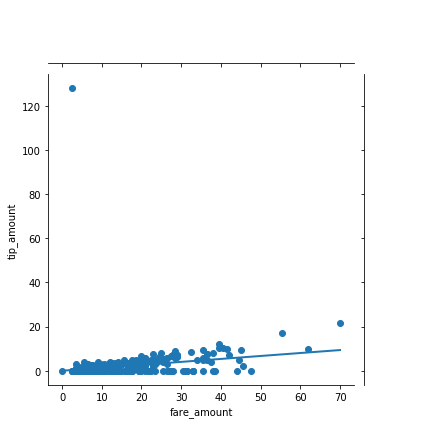

In [205]:
y1 = ytips.predict(0)
y2 = ytips.predict(70)
graph = sns.JointGrid(ydata['fare_amount'].head(500), ydata['tip_amount'].head(500))
graph.plot_joint(plt.scatter)
plt.plot([0, 70], [y1, y2], linewidth=2)
plt.show()

Looking at this graph, it's clear why our data is less linear for this problem. There's a strong possibility for outliers, like the $120 tip, and some people simply don't tip.

While we would normally expect some people not to tip, there is a larger problem here - missing data.

It is inevitable that data should be missing from a set, but unfortunately, this data handles it in a peculiar way.
According to the website, this field is automatically populated with tips made via credit card, but entirely excludes cash tips as they are not tracked.

This is problematic for us, as this represents data that is Missing at Random, as it is based on payment type.

We, as analysts, must decide how to handle the problem of missing data.

We could remove all tips with the value 0, but this would also remove any valid $0 tips that had been made.

Fortunately, we have the column payment_type, which tells us what method the passenger paid for the trip with.
By only analyzing those columns with a value of 1, we can remove a lot of data that is guaranteed to be missing.
While some passengers may par the fare with their credit card and the tip with cash, this is at least removing data that we know to be missing.

In [206]:
nocash = ydata.loc[ydata['payment_type'] == 1] #Make a set of only credit card users

y = np.array(nocash['tip_amount'])
X = np.array(nocash['fare_amount'])
model = sm.OLS(y,X)
nocashtips = model.fit()

In [207]:
nocashtips.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                 3.150e+05
Date:                Sat, 15 Dec 2018   Prob (F-statistic):               0.00
Time:                        14:41:11   Log-Likelihood:            -1.8982e+05
No. Observations:              101334   AIC:                         3.796e+05
Df Residuals:                  101333   BIC:                         3.796e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1843      0.000    561.270      0.000       0.184       0.185
==============================================================================
Omnibus:                   179022.262   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3242363222.906
Skew:                          11.571   Prob(JB):                         0.00
Kurtosis:                     879.007   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As you can see, we've managed to increase the score by a pretty significant amount by ridding the data set of a slew of missing tip entries.
Let's look at our new graph.

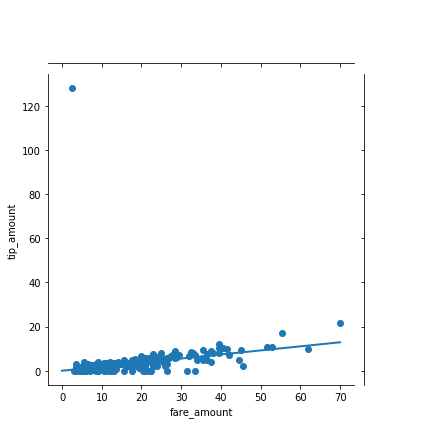

In [208]:
y1 = nocashtips.predict(0)
y2 = nocashtips.predict(70)
graph = sns.JointGrid(nocash['fare_amount'].head(500), nocash['tip_amount'].head(500))
graph.plot_joint(plt.scatter)
plt.plot([0, 70], [y1, y2], linewidth=2)
plt.show()

As you can see, removing most of our missing data has increased the accuracy of our predictions.
Notably, we don't see quite as many false 0s at high fare amounts, probably because most people are not paying with cash for
very large fares.

Now, let's take a look at a regression of time as a function of distance.

In [209]:
y = np.array(ydata['time_seconds']).reshape(145426, 1)
X = np.array(ydata['trip_distance']).reshape(145426, 1)
model = sm.OLS(y,X)
yspeed = model.fit()
yspeed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     9289.
Date:                Sat, 15 Dec 2018   Prob (F-statistic):               0.00
Time:                        14:41:11   Log-Likelihood:            -1.4057e+06
No. Observations:              145426   AIC:                         2.811e+06
Df Residuals:                  145425   BIC:                         2.811e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           231.4820      2.402     96.379      0.000     226.775     236.189
==============================================================================
Omnibus:                   323359.749   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1423854790.726
Skew:                          21.108   Prob(JB):                         0.00
Kurtosis:                     485.908   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [210]:
y = np.array(gdata['time_seconds']).reshape(147257, 1)
X = np.array(gdata['trip_distance']).reshape(147257, 1)
model = sm.OLS(y,X)
gspeed = model.fit()
gspeed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     8205.
Date:                Sat, 15 Dec 2018   Prob (F-statistic):               0.00
Time:                        14:41:11   Log-Likelihood:            -1.4894e+06
No. Observations:              147257   AIC:                         2.979e+06
Df Residuals:                  147256   BIC:                         2.979e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           288.3678      3.183     90.583      0.000     282.128     294.607
==============================================================================
Omnibus:                   265193.940   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        216606915.926
Skew:                          13.584   Prob(JB):                         0.00
Kurtosis:                     188.915   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our overall linearity looks good, as our pvalues allow us to reject the null hypothesis. Let's look at the individual graphs first.

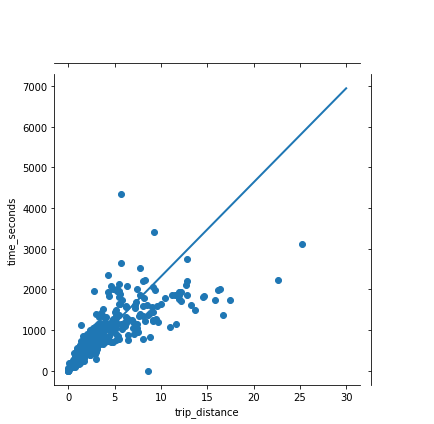

In [211]:
y1 = yspeed.predict(0)
y2 = yspeed.predict(30)

graph = sns.JointGrid(ydata['trip_distance'].head(500), ydata['time_seconds'].head(500))
graph.plot_joint(plt.scatter)
plt.plot([0, 30], [y1, y2], linewidth=2)
plt.show()

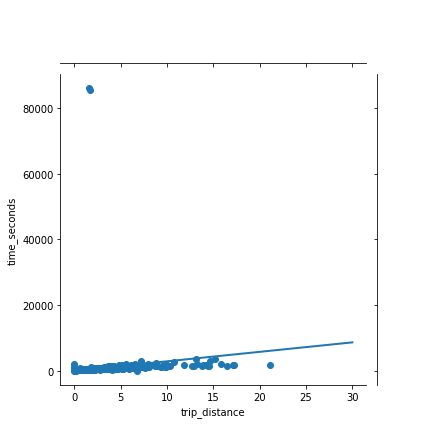

In [212]:
y1 = gspeed.predict(0)
y2 = gspeed.predict(30)

graph = sns.JointGrid(gdata['trip_distance'].head(500), gdata['time_seconds'].head(500))
graph.plot_joint(plt.scatter)
plt.plot([0, 30], [y1, y2], linewidth=2)
plt.show()

First of all, our gdata has some big outliers that clearly make the graph difficult to read, so we need to exclude these problem points to get a better visualization of the green taxi data.

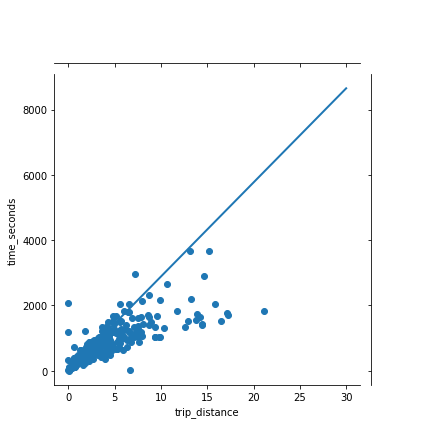

In [213]:
y1 = gspeed.predict(0)
y2 = gspeed.predict(30)
nooutlier = gdata.loc[gdata['time_seconds'] < 10000]

graph = sns.JointGrid(nooutlier['trip_distance'].head(500), nooutlier['time_seconds'].head(500))
graph.plot_joint(plt.scatter)
plt.plot([0, 30], [y1, y2], linewidth=2)
plt.show()

Both of these graphs are also clearly good predictors. 
Up until this point, we have been focusing only on data from the sets separately.
Let's branch out a bit, and try to make some practical conclusions from our regressions.
For this next section, let's compare the two data sets.
If, for example, I wanted to travel a certain distance, which service should I call to get a cheaper service?

In [214]:
y = np.array(gdata['fare_amount'])
X = np.array(gdata['trip_distance'])
model = sm.OLS(y,X)
gregression= model.fit()

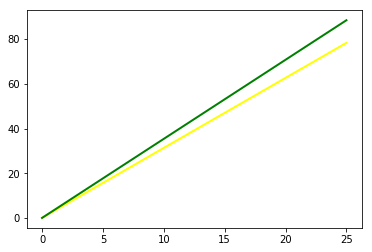

In [215]:
y1 = regression.predict(0)
y2 = regression.predict(25)
g1 = gregression.predict(0)
g2 = gregression.predict(25)
plt.plot([0, 25], [y1, y2], linewidth=2, color = "yellow")
plt.plot([0, 25], [g1, g2], linewidth=2, color= "green")
plt.show()

Based on our regression, we can see that the Green Cab is slightly more expensive for pretty much
any distance of travel.
It may be the case that they spend more time in traffic or waiting, as the ticker does go up for time reasons in addition to plain distance.

Say that instead we're an aspiring taxi driver with a bit of knowledge about data science, and want to see which service to work for based on the tipping patterns.

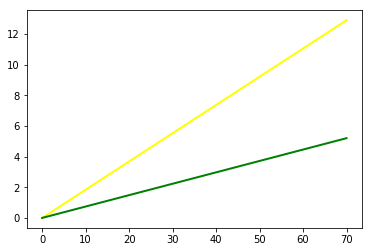

In [216]:
nocash = gdata.loc[gdata['payment_type'] == 1]
y = np.array(nocash['tip_amount'])
X = np.array(nocash['fare_amount'])
model = sm.OLS(y,X)
gtips = model.fit()

y1 = nocashtips.predict(0)
y2 = nocashtips.predict(70)
g1 = gtips.predict(0)
g2 = gtips.predict(70)

plt.plot([0, 70], [y1, y2], linewidth=2, color = "yellow")
plt.plot([0, 70], [g1, g2], linewidth=2, color="green")
plt.show()

Based on our models, it seems as though Yellow Cab drivers receive better tips on average, and our data scientist taxi driver should probably choose this company if this is their basis for joining.

Finally, let's pretend that we're looking for the faster taxi service because we're in quite a rush.

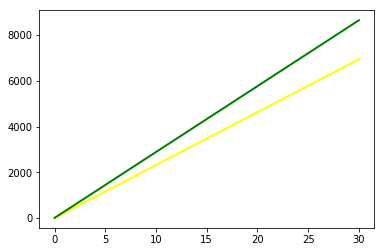

In [218]:
g1 = gspeed.predict(0)
g2 = gspeed.predict(30)
y1 = yspeed.predict(0)
y2 = yspeed.predict(30)

plt.plot([0, 30], [y1, y2], linewidth=2, color = "yellow")
plt.plot([0, 30], [g1, g2], linewidth=2, color="green")
plt.show()

Based on this information, it seems that Green Cab is somewhat slower, as they take slightly more time to travel the same distance, based on our regressions.

                                                 Messages and Conclusion
Based on the regressions that we did, it seems as though Yellow cab is a superior service. In each of the comparisons, Yellow cab was cheaper, faster, and gets the driver better tips. On the other hand, there are certainly metrics that were not covered in this tutorial, and you should feel free to explore them as practice.

This particular tutorial covers the basics of data science using linear regression because of the linear nature of the data. Different methods of analysis for categorical data and non-linear continuous data do exist in statsmodels, which was used for this tutorial, and scikit-learn, the documentation for which can be found here: 
https://scikit-learn.org/stable/documentation.html

Overall, I hope that this tutorial was useful for you in your journey to become a data scientist!